---
date: "2023-05-16"
categories: [code, analysis]
image: "geopandas.jpg"
---

**This notebook is an exercise in the [Geospatial Analysis](https://www.kaggle.com/learn/geospatial-analysis) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/coordinate-reference-systems).**

---


# Introduction

You are a bird conservation expert and want to understand migration patterns of purple martins.  In your research, you discover that these birds typically spend the summer breeding season in the eastern United States, and then migrate to South America for the winter.  But since this bird is under threat of endangerment, you'd like to take a closer look at the locations that these birds are more likely to visit.

<center>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/qQcS0KM.png" width="1000"><br/>
</center>

There are several [protected areas](https://www.iucn.org/theme/protected-areas/about) in South America, which operate under special regulations to ensure that species that migrate (or live) there have the best opportunity to thrive.  You'd like to know if purple martins tend to visit these areas.  To answer this question, you'll use some recently collected data that tracks the year-round location of eleven different birds.

Before you get started, run the code cell below to set everything up.

In [4]:
import pandas as pd
import geopandas as gpd

#from shapely.geometry import LineString

#from learntools.core import binder
##binder.bind(globals())
#from learntools.geospatial.ex2 import *

# Exercises

### 1) Load the data.

Run the next code cell (without changes) to load the GPS data into a pandas DataFrame `birds_df`.  

In [5]:
# Load the data and print the first 5 rows
birds_df = pd.read_csv("/Users/chojs/Desktop/Dataming_class/archive/purple_martin.csv", parse_dates=['timestamp'])
print("There are {} different birds in the dataset.".format(birds_df["tag-local-identifier"].nunique()))
birds_df.head()

There are 11 different birds in the dataset.


,timestamp,location-long,location-lat,tag-local-identifier
0,2014-08-15 05:56:00,-88.146014,17.513049,30448
1,2014-09-01 05:59:00,-85.243501,13.095782,30448
2,2014-10-30 23:58:00,-62.906089,-7.852436,30448
3,2014-11-15 04:59:00,-61.776826,-11.723898,30448
4,2014-11-30 09:59:00,-61.241538,-11.612237,30448


There are 11 birds in the dataset, where each bird is identified by a unique value in the "tag-local-identifier" column.  Each bird has several measurements, collected at different times of the year.

Use the next code cell to create a GeoDataFrame `birds`.  
- `birds` should have all of the columns from `birds_df`, along with a "geometry" column that contains Point objects with (longitude, latitude) locations.  
- Set the CRS of `birds` to `{'init': 'epsg:4326'}`.

In [6]:
# Your code here: Create the GeoDataFrame
birds = gpd.GeoDataFrame(birds_df, geometry=gpd.points_from_xy(birds_df["location-long"], birds_df["location-lat"]))

# Your code here: Set the CRS to {'init': 'epsg:4326'}
birds.crs = {'init':'epsg:4326'}

/Users/chojs/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### 2) Plot the data.

Next, we load in the `'naturalearth_lowres'` dataset from GeoPandas, and set `americas` to a GeoDataFrame containing the boundaries of all countries in the Americas (both North and South America).  Run the next code cell without changes.

In [7]:
# Load a GeoDataFrame with country boundaries in North/South America, print the first 5 rows
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
americas = world.loc[world['continent'].isin(['North America', 'South America'])]
americas.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
9,44938712.0,South America,Argentina,ARG,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
10,18952038.0,South America,Chile,CHL,282318,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335..."
16,11263077.0,North America,Haiti,HTI,14332,"POLYGON ((-71.71236 19.71446, -71.62487 19.169..."


In [8]:
americas.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Use the next code cell to create a single plot that shows both: (1) the country boundaries in the `americas` GeoDataFrame, and (2) all of the points in the `birds_gdf` GeoDataFrame.  

Don't worry about any special styling here; just create a preliminary plot, as a quick sanity check that all of the data was loaded properly.  In particular, you don't have to worry about color-coding the points to differentiate between birds, and you don't have to differentiate starting points from ending points.  We'll do that in the next part of the exercise.

<Axes: >

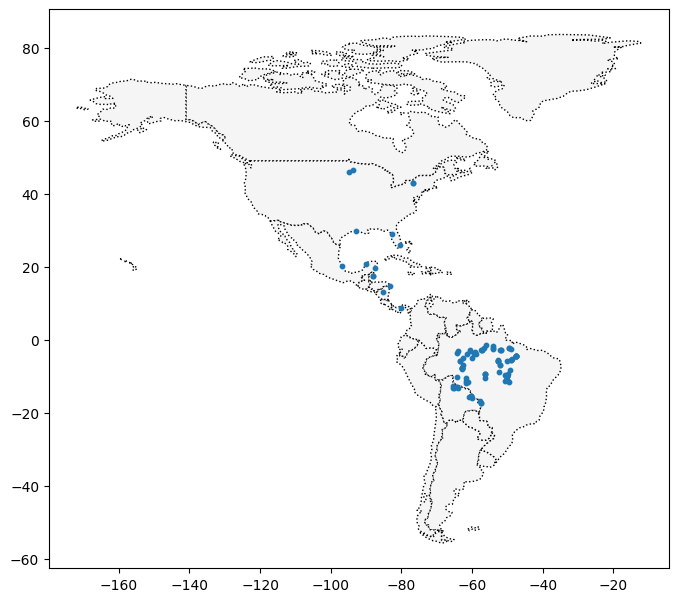

In [9]:
# Your code here
ax = americas.plot(figsize=(8,8), color='whitesmoke', linestyle=':', edgecolor='black')
birds.plot(markersize=10, ax=ax)


### 3) Where does each bird start and end its journey? (Part 1)

Now, we're ready to look more closely at each bird's path.  Run the next code cell to create two GeoDataFrames:
- `path_gdf` contains LineString objects that show the path of each bird.  It uses the `LineString()` method to create a LineString object from a list of Point objects.
- `start_gdf` contains the starting points for each bird.

In [11]:
# GeoDataFrame showing path for each bird
path_df = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: LineString(x)).reset_index()
path_gdf = gpd.GeoDataFrame(path_df, geometry=path_df.geometry)
path_gdf.crs = {'init' :'epsg:4326'}

# GeoDataFrame showing starting point for each bird
start_df = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: x[0]).reset_index()
start_gdf = gpd.GeoDataFrame(start_df, geometry=start_df.geometry)
start_gdf.crs = {'init' :'epsg:4326'}

# Show first five rows of GeoDataFrame
start_gdf.head()

NameError: name 'LineString' is not defined

Use the next code cell to create a GeoDataFrame `end_gdf` containing the final location of each bird.  
- The format should be identical to that of `start_gdf`, with two columns ("tag-local-identifier" and "geometry"), where the "geometry" column contains Point objects.
- Set the CRS of `end_gdf` to `{'init': 'epsg:4326'}`.

In [12]:
# Your code here
end_df = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: x[-1]).reset_index()
end_gdf = gpd.GeoDataFrame(end_df, geometry=end_df.geometry)
end_gdf.crs = {'init': 'epsg:4326'}


/Users/chojs/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### 4) Where does each bird start and end its journey? (Part 2)

Use the GeoDataFrames from the question above (`path_gdf`, `start_gdf`, and `end_gdf`) to visualize the paths of all birds on a single map.  You may also want to use the `americas` GeoDataFrame.

NameError: name 'start_gdf' is not defined

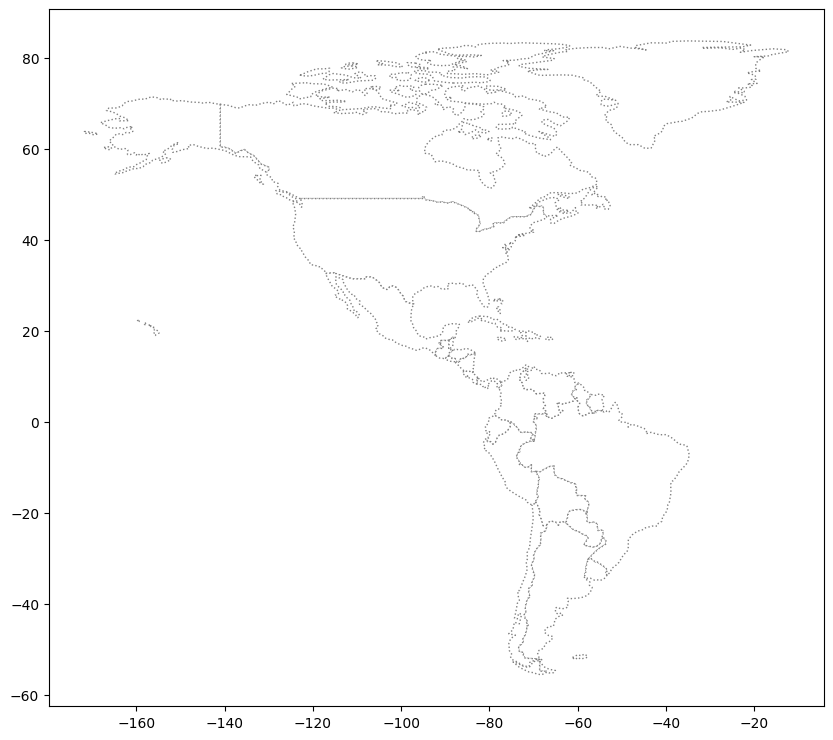

In [13]:
# Your code here
ax = americas.plot(figsize=(10, 10), color='white', linestyle=':', edgecolor='gray')

start_gdf.plot(ax=ax, color='red',  markersize=30)
path_gdf.plot(ax=ax, cmap='tab20b', linestyle='-', linewidth=1, zorder=1)
end_gdf.plot(ax=ax, color='black', markersize=30)

### 5) Where are the protected areas in South America? (Part 1)

It looks like all of the birds end up somewhere in South America.  But are they going to protected areas?

In the next code cell, you'll create a GeoDataFrame `protected_areas` containing the locations of all of the protected areas in South America.  The corresponding shapefile is located at filepath `protected_filepath`.

In [15]:
# Path of the shapefile to load
protected_filepath = "/Users/chojs/Desktop/Dataming_class/archive/SAPA_Aug2019-shapefile/SAPA_Aug2019-shapefile/SAPA_Aug2019-shapefile-polygons.shp"

# Your code here
protected_areas = gpd.read_file(protected_filepath)

### 6) Where are the protected areas in South America? (Part 2)

Create a plot that uses the `protected_areas` GeoDataFrame to show the locations of the protected areas in South America.  (_You'll notice that some protected areas are on land, while others are in marine waters._)

<Axes: >

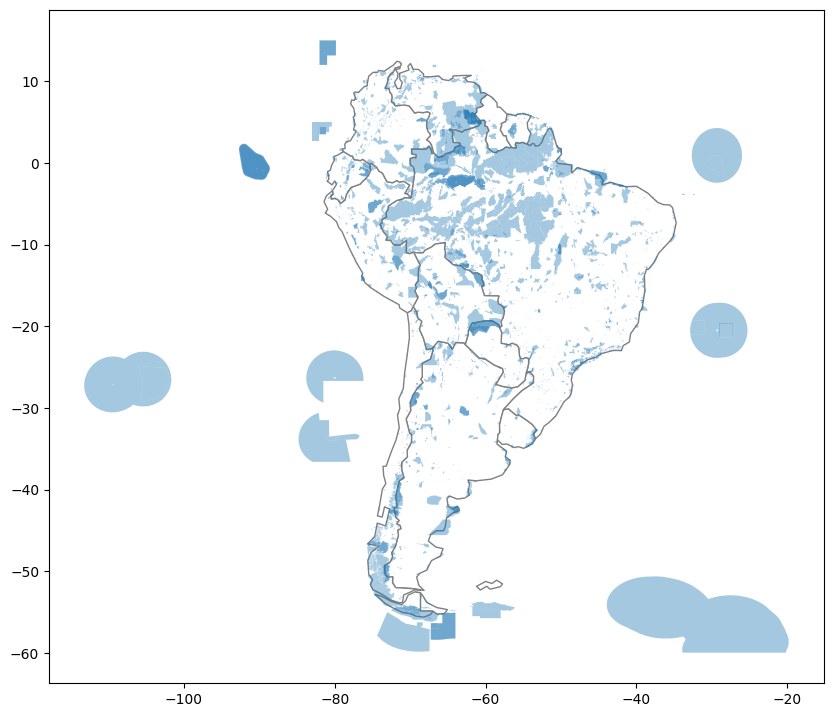

In [16]:
# Country boundaries in South America
south_america = americas.loc[americas['continent']=='South America']

# Your code here: plot protected areas in South America
ax = south_america.plot(figsize=(10,10), color='white', edgecolor='gray')
protected_areas.plot(ax=ax, alpha=0.4)

### 7) What percentage of South America is protected?

You're interested in determining what percentage of South America is protected, so that you know how much of South America is suitable for the birds.  

As a first step, you calculate the total area of all protected lands in South America (not including marine area).  To do this, you use the "REP_AREA" and "REP_M_AREA" columns, which contain the total area and total marine area, respectively, in square kilometers.

Run the code cell below without changes.

In [17]:
P_Area = sum(protected_areas['REP_AREA']-protected_areas['REP_M_AREA'])
print("South America has {} square kilometers of protected areas.".format(P_Area))

South America has 5396761.9116883585 square kilometers of protected areas.


Then, to finish the calculation, you'll use the `south_america` GeoDataFrame.  

In [18]:
south_america.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
9,44938712.0,South America,Argentina,ARG,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
10,18952038.0,South America,Chile,CHL,282318,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335..."
20,3398.0,South America,Falkland Is.,FLK,282,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2..."
28,3461734.0,South America,Uruguay,URY,56045,"POLYGON ((-57.62513 -30.21629, -56.97603 -30.1..."
29,211049527.0,South America,Brazil,BRA,1839758,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2..."


Calculate the total area of South America by following these steps:
- Calculate the area of each country using the `area` attribute of each polygon (with EPSG 3035 as the CRS), and add up the results.  The calculated area will be in units of square meters.
- Convert your answer to have units of square kilometeters.

In [19]:
# Your code here: Calculate the total area of South America (in square kilometers)
totalArea = sum(south_america.geometry.to_crs(epsg=3035).area) / 10**6

Run the code cell below to calculate the percentage of South America that is protected.

In [20]:
# What percentage of South America is protected?
percentage_protected = P_Area/totalArea
print('Approximately {}% of South America is protected.'.format(round(percentage_protected*100, 2)))

Approximately 30.39% of South America is protected.


### 8) Where are the birds in South America?

So, are the birds in protected areas?  

Create a plot that shows for all birds, all of the locations where they were discovered in South America.  Also plot the locations of all protected areas in South America.

To exclude protected areas that are purely marine areas (with no land component), you can use the "MARINE" column (and plot only the rows in `protected_areas[protected_areas['MARINE']!='2']`, instead of every row in the `protected_areas` GeoDataFrame).

<Axes: >

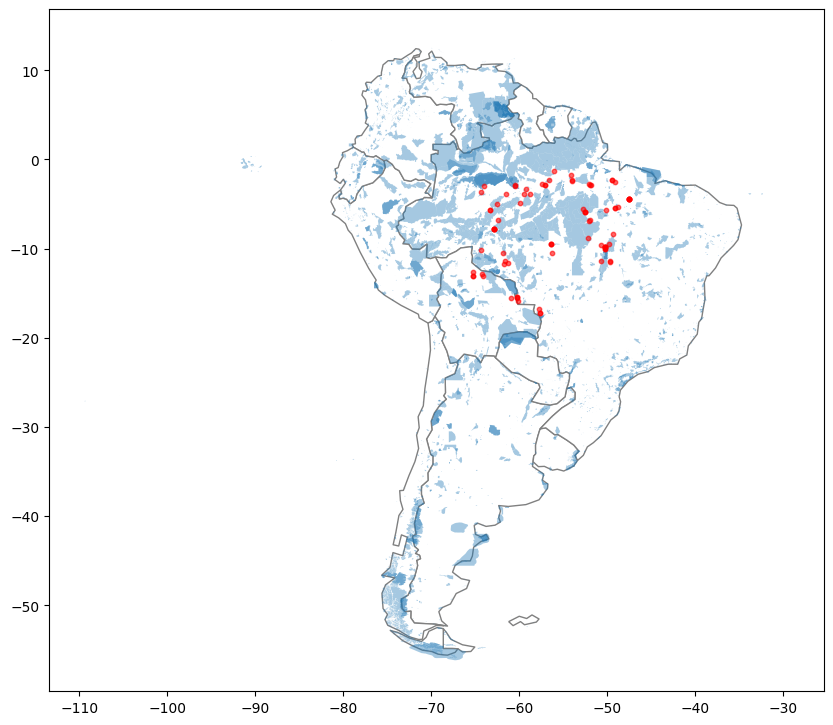

In [21]:
# Your code here
ax = south_america.plot(figsize=(10,10), color='white', edgecolor='gray')
protected_areas[protected_areas['MARINE']!='2'].plot(ax=ax, alpha=0.4, zorder=1)
birds[birds.geometry.y < 0].plot(ax=ax, color='red', alpha=0.6, markersize=10, zorder=2)

# Keep going

Create stunning **[interactive maps](https://www.kaggle.com/alexisbcook/interactive-maps)** with your geospatial data.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/geospatial-analysis/discussion) to chat with other learners.*